In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from datetime import date, datetime
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model  [Declare a Base using `automap_base()`]
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
latest_date = session.query(func.max(Measurement.date)).scalar()
latest_date

'2017-08-23'

In [12]:
# Prepare labels for every month between min and max dates
# xmin = datetime.datetime(2016,8,23,0,0,0)
xmin = date(2016, 8, 23)
xmax = xmin + relativedelta(months=12)

xlabels = []
present = xmin - relativedelta(months=1)
for i in range(13):
    present = present + relativedelta(months=1)
    xlabels.append(datetime.strftime(present, '%Y-%m-%d'))

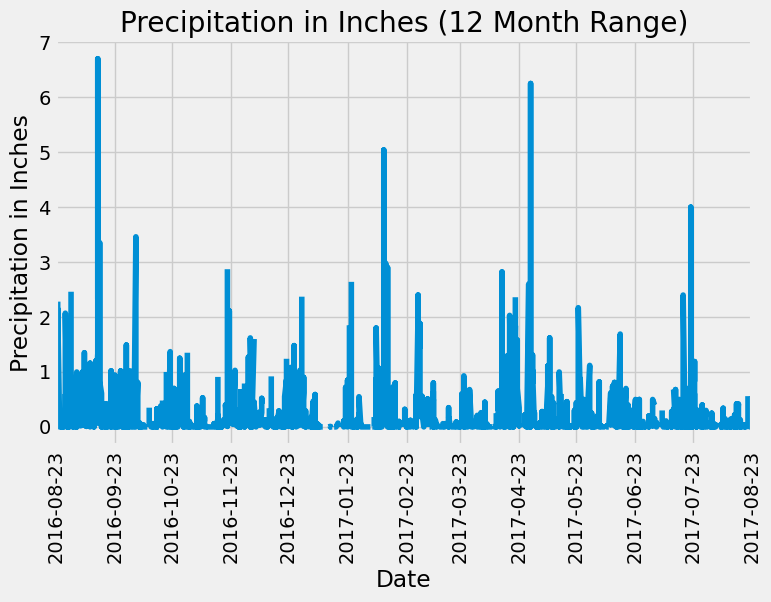

In [20]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_twelve_months = (datetime.strptime(latest_date, '%Y-%m-%d') - pd.DateOffset(months=12)).date()

# Perform a query to retrieve the data and precipitation scores
last_12_months = session.query(Measurement.date, Measurement.prcp).\
                   filter(Measurement.date >= last_twelve_months)

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(last_12_months, columns=['Date', 'Precipitation']) 
precipitation_df.set_index('Date', inplace=True)

# Drop all rows with Nan in any column
# precipitation_df.dropna(how='all')

# Sort the dataframe by date
sorted_df = precipitation_df.sort_values(by='Date')
x_axis = sorted_df.index.tolist()
y_axis = sorted_df['Precipitation'].tolist()

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(8)

ax.plot(x_axis, y_axis)
ax.set_xlim([xmin.strftime("%Y-%m-%d"), xmax.strftime("%Y-%m-%d")])
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, rotation=90)

ax.set_xlabel('Date')
ax.set_ylabel('Precipitation in Inches')
ax.set_title('Precipitation in Inches (12 Month Range)')

plt.savefig('../Images/precipitation.png')
plt.show()

In [21]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sorted_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [22]:
# Design a query to calculate the total number stations in the dataset
# stations_count = session.query(Station).count()      ---Ans:9
stations_count = session.query(Measurement.station).distinct().count()
print(f"Number of stations: {stations_count}")

Number of stations: 9


In [23]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
count_ary = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
              order_by(func.count(Measurement.station).desc()).all()
count_ary

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [24]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = count_ary[0].station
lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.tobs).scalar()
highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.tobs).scalar()
average_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.tobs).scalar()
print(f'Station {most_active_station} has lowest temperature of {lowest_temp}, \
highest temperature of {highest_temp} and an average of {average_temp:.2f}')

Station USC00519281 has lowest temperature of 53.0, highest temperature of 87.0 and an average of 73.10


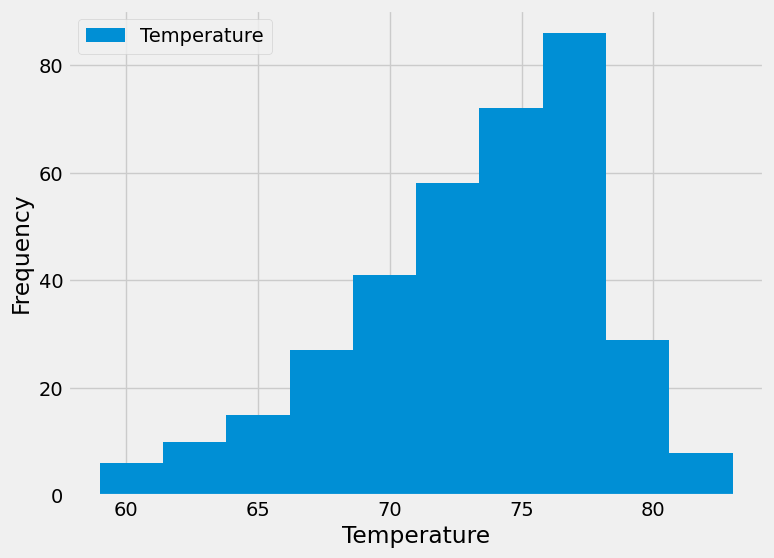

In [25]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_last_12months = session.query(Measurement.date, Measurement.tobs).\
                   filter(Measurement.date >= last_twelve_months).filter(Measurement.station == most_active_station).all()

# Getting results into pandas dataframe and changing Temperature column from float to integer
temperature_df = pd.DataFrame(temp_last_12months, columns=['Date', 'Temperature'])
temperature_df['Temperature'] = temperature_df['Temperature'].astype(int)

# Plot pandas histogram to display distribution of temperature
ax2 = temperature_df.plot(kind='hist', figsize=(8,6))
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Frequency')

plt.savefig("../Images/station_tobs.png")
plt.show()

# Close session

In [26]:
# Close Session
session.close()